In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable 


In [2]:
mobi_data = pd.read_csv("../data/Mobi_System_Data_2020.csv", compression='zip').dropna()
geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
data = data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
data.shape
# data = data.loc[data["Departure postal code"].str.startswith("V6")]
print(data.columns)
data["time"] = pd.to_datetime(data["Departure"], format="%Y-%m-%d %H:%M:%S")
data["hour"] = data["time"].dt.hour
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year

# train_data = data[["year", "month", "day", "hour", "Departure lat", "Departure long"]]
features_departure = ["month", "day", "hour", "Departure lat", "Departure long"]
counts_data = data.groupby(["month", "day", "hour", "Departure lat", "Departure long", "Departure station"]).size().reset_index(name='counts')


Index(['Unnamed: 0', 'Departure', 'Return', 'Bike', 'Departure station',
       'Return station', 'Membership type', 'Covered distance (m)',
       'Duration (sec.)', 'Departure battery voltage (mV)',
       'Return battery voltage (mV)', 'Departure temperature (C)',
       'Return temperature (C)', 'Stopover duration (sec.)',
       'Number of stopovers', 'postal_code_x', 'Departure lat',
       'Departure long', 'postal_code_y', 'Return lat', 'Return long'],
      dtype='object')


In [3]:
stations = data[["Departure lat", "Departure long", "Departure station"]].drop_duplicates()
max_lat, min_lat = stations["Departure lat"].max(), stations["Departure lat"].min()
max_long, min_long = stations["Departure long"].max(), stations["Departure long"].min()
batch = stations.shape[0]
print(batch)
predict_data_departure = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": []})
for row in stations.iterrows():
    time = pd.date_range('2020-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["Departure lat"] = (row[1]["Departure lat"] - min_lat) / (max_lat - min_lat)
    station_data["Departure long"] = (row[1]["Departure long"] - min_long) / (max_long - min_long)
    station_data["Departure station"] = row[1]["Departure station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])

train_data = predict_data_departure.merge(counts_data[["month", "day", "hour", "Departure station", "counts"]], how="left", left_on=["month", "day", "hour", "Departure station"], right_on=["month", "day", "hour", "Departure station"])
train_data["counts"] = train_data["counts"].fillna(0)
train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
# train_data = train_data.sort_values(by="Departure station")
print(train_data)
x = train_data[features_departure]
y = train_data["counts"]
    



221
            month       day      hour  Departure lat  Departure long  \
0        0.083333  0.032258  0.000000       0.693601        0.000627   
1        0.083333  0.032258  0.043478       0.693601        0.000627   
2        0.083333  0.032258  0.086957       0.693601        0.000627   
3        0.083333  0.032258  0.130435       0.693601        0.000627   
4        0.083333  0.032258  0.173913       0.693601        0.000627   
...           ...       ...       ...            ...             ...   
1935955  1.000000  0.967742  0.826087       0.284948        0.841722   
1935956  1.000000  0.967742  0.869565       0.284948        0.841722   
1935957  1.000000  0.967742  0.913043       0.284948        0.841722   
1935958  1.000000  0.967742  0.956522       0.284948        0.841722   
1935959  1.000000  0.967742  1.000000       0.284948        0.841722   

                                Departure station  counts  
0        0099 Vancouver Art Gallery - North Plaza     1.0  
1        00

In [4]:
from xgboost import XGBRegressor
model_departure = XGBRegressor()
model_departure.fit(x, y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [5]:
predict_data_departure = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": [],})
for row in stations.iterrows():
    time = pd.date_range('2022-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour / 23
    station_data["day"] = station_data["time"].dt.day / 31
    station_data["month"] = station_data["time"].dt.month / 12
    station_data["Departure lat"] = (row[1]["Departure lat"] - min_lat) / (max_lat - min_lat)
    station_data["Departure long"] = (row[1]["Departure long"] - min_long) / (max_long - min_long)
    station_data["Departure station"] = row[1]["Departure station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])

predict_data_departure["counts"] = model_departure.predict(predict_data_departure[features_departure])

E:\anaconda\envs\cmpt733\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'# of Departure for each hour'}, xlabel='hour'>

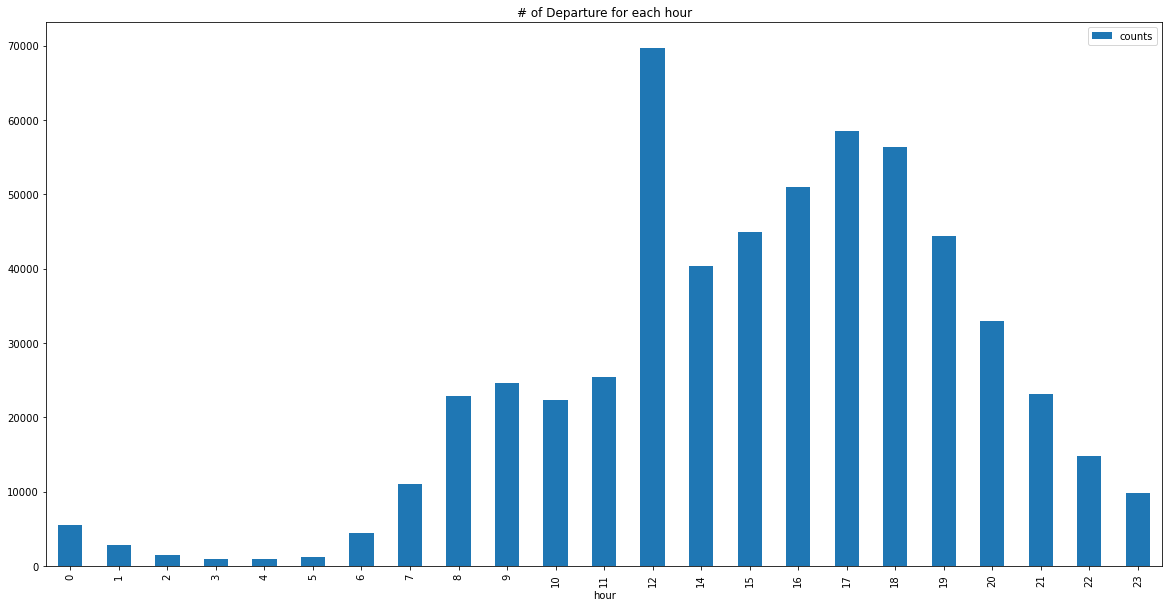

In [6]:
hours = predict_data_departure[["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).astype(int)
hours = hours.groupby("hour").sum()
# hours.plot.line(figsize=(20, 10)).set_ylabel("# of bikes");
hours.plot(kind='bar', figsize=(20, 10), title="# of Departure for each hour")
# print(hours)

E:\anaconda\envs\cmpt733\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


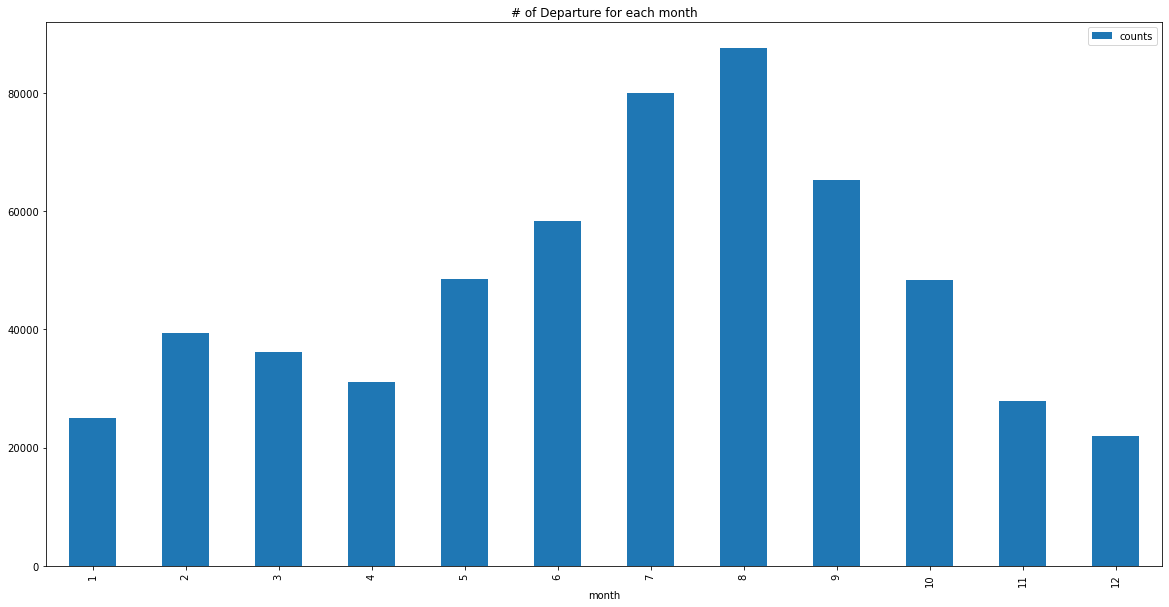

In [7]:
month = predict_data_departure[["month", "counts"]]
month["month"] = (month["month"] * 12).astype(int)
month = month.groupby("month").sum()
month.plot(kind='bar', figsize=(20, 10), title="# of Departure for each month");

[Text(0.5, 1.0, 'Top 10 departure stations')]

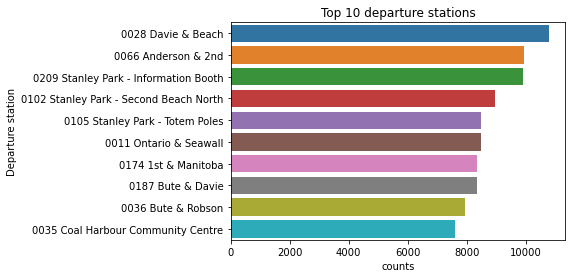

In [8]:
stations = predict_data_departure[["Departure station", "counts"]].groupby("Departure station").sum().reset_index()
stations = stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Departure station", data=stations)
ax.set(title="Top 10 departure stations")
# stations.sort_values(by="counts", ascending= False).head(10).plot(kind='bar', figsize=(20, 10));

In [10]:
features_return = ["month", "day", "hour", "Return lat", "Return long"]
counts_data = data.groupby(["month", "day", "hour", "Return lat", "Return long", "Return station"]).size().reset_index(name='counts')
stations = data[["Return lat", "Return long", "Return station"]].drop_duplicates()
max_lat, min_lat = stations["Return lat"].max(), stations["Return lat"].min()
max_long, min_long = stations["Return long"].max(), stations["Return long"].min()
batch = stations.shape[0]
print(batch)
predict_data_return = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Return lat": [],
    "Return long": []})
for row in stations.iterrows():
    time = pd.date_range('2020-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["Return lat"] = (row[1]["Return lat"] - min_lat) / (max_lat - min_lat)
    station_data["Return long"] = (row[1]["Return long"] - min_long) / (max_long - min_long)
    station_data["Return station"] = row[1]["Return station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_return = pd.concat([predict_data_return, station_data])

train_data = predict_data_return.merge(counts_data[["month", "day", "hour", "Return station", "counts"]], how="left", left_on=["month", "day", "hour", "Return station"], right_on=["month", "day", "hour", "Return station"])
train_data["counts"] = train_data["counts"].fillna(0)
train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
# train_data = train_data.sort_values(by="Departure station")
print(train_data)
x = train_data[features_return]
y = train_data["counts"]
    

221
            month       day      hour  Return lat  Return long  \
0        0.083333  0.032258  0.000000    0.692950     0.000472   
1        0.083333  0.032258  0.043478    0.692950     0.000472   
2        0.083333  0.032258  0.086957    0.692950     0.000472   
3        0.083333  0.032258  0.130435    0.692950     0.000472   
4        0.083333  0.032258  0.173913    0.692950     0.000472   
...           ...       ...       ...         ...          ...   
1935955  1.000000  0.967742  0.826087    0.665287     0.013134   
1935956  1.000000  0.967742  0.869565    0.665287     0.013134   
1935957  1.000000  0.967742  0.913043    0.665287     0.013134   
1935958  1.000000  0.967742  0.956522    0.665287     0.013134   
1935959  1.000000  0.967742  1.000000    0.665287     0.013134   

                        Return station  counts  
0                  0196 Drake & Hornby     0.0  
1                  0196 Drake & Hornby     0.0  
2                  0196 Drake & Hornby     0.0  
3      

In [11]:
from xgboost import XGBRegressor
model_return = XGBRegressor()
model_return.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [12]:
predict_data_return = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Return lat": [],
    "Return long": [],})
for row in stations.iterrows():
    time = pd.date_range('2022-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour / 23
    station_data["day"] = station_data["time"].dt.day / 31
    station_data["month"] = station_data["time"].dt.month / 12
    station_data["Return lat"] = (row[1]["Return lat"] - min_lat) / (max_lat - min_lat)
    station_data["Return long"] = (row[1]["Return long"] - min_long) / (max_long - min_long)
    station_data["Return station"] = row[1]["Return station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_return = pd.concat([predict_data_return, station_data])

predict_data_return["counts"] = model_return.predict(predict_data_return[features_return])

E:\anaconda\envs\cmpt733\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'# of Return for each hour'}, xlabel='hour'>

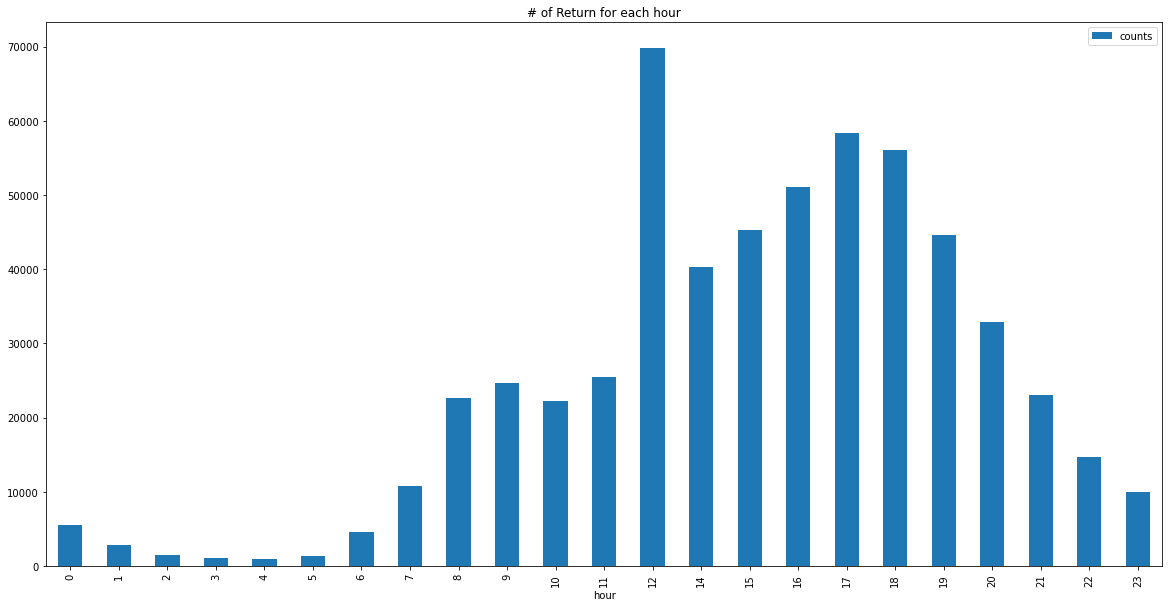

In [17]:
hours = predict_data_return[["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).astype(int)
hours = hours.groupby("hour").sum()
# hours.plot.line(figsize=(20, 10)).set_ylabel("# of bikes");
hours.plot(kind='bar', figsize=(20, 10), title="# of Return for each hour")
# print(hours)

E:\anaconda\envs\cmpt733\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


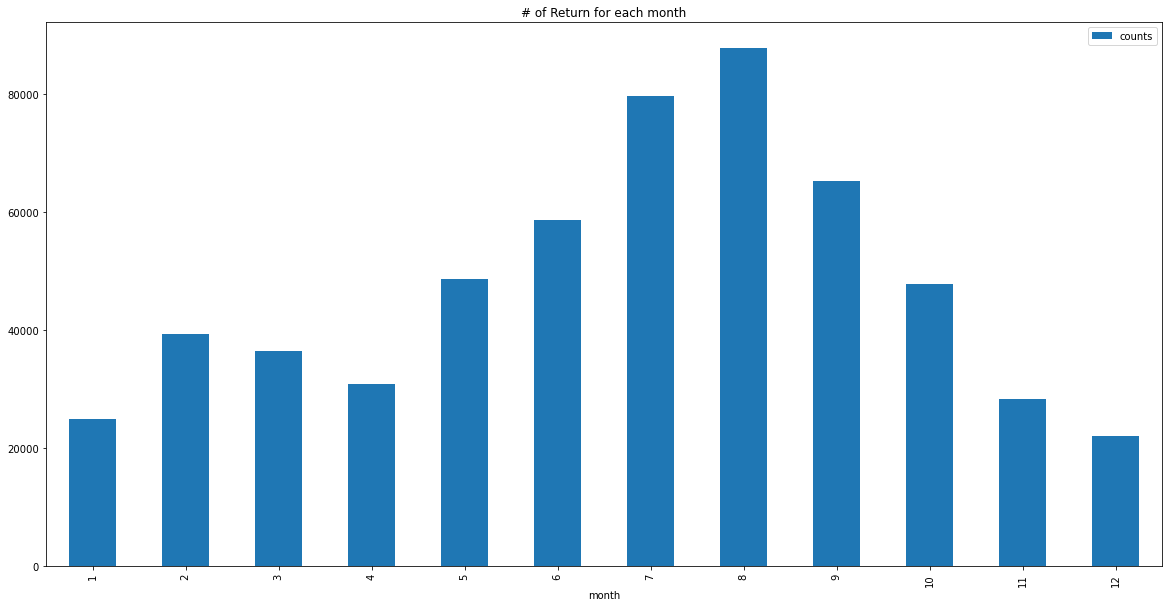

In [18]:
month = predict_data_return[["month", "counts"]]
month["month"] = (month["month"] * 12).astype(int)
month = month.groupby("month").sum()
month.plot(kind='bar', figsize=(20, 10), title="# of Return for each month");

[Text(0.5, 1.0, 'Top 10 return stations')]

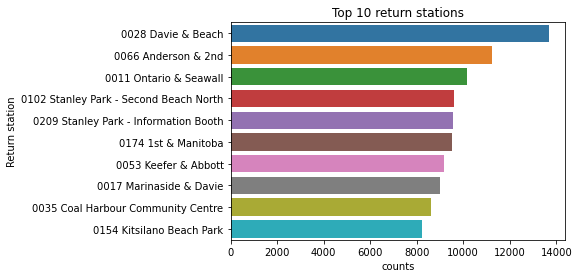

In [15]:
stations = predict_data_return[["Return station", "counts"]].groupby("Return station").sum().reset_index()
stations = stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Return station", data=stations)
ax.set(title='Top 10 return stations')

In [36]:
predict_data = predict_data_departure.merge(
    predict_data_return, 
    left_on=['Departure station', "month", "day", "hour"],
    right_on=['Return station', "month", "day", "hour"])
predict_data["ratio"] = predict_data["counts_x"] / predict_data["counts_y"]
predict_data = predict_data.rename(columns={'Departure lat': 'lat', 'Departure long': 'long', 'Departure station': 'station'})
predict_data = predict_data[["lat", "long", "station", "month", "day", "hour", "ratio", "counts_x", "counts_y"]]
predict_data["month"] = (predict_data["month"] * 12).astype(int)
predict_data["day"] = (predict_data["day"] * 31).astype(int)
predict_data["hour"] = (predict_data["hour"] * 23).astype(int)

In [38]:
ratio_data = predict_data.loc[
    (predict_data["ratio"] > 2) & (predict_data["ratio"] < 5) & (predict_data["counts_x"] > 1) & (predict_data["counts_y"] > 1)].sort_values(by="ratio", ascending=False).head(10)
print(ratio_data)


              lat      long                                      station  \
1196253  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot   
1240797  0.694911  0.000119       0102 Stanley Park - Second Beach North   
1240989  0.694911  0.000119       0102 Stanley Park - Second Beach North   
1240725  0.694911  0.000119       0102 Stanley Park - Second Beach North   
1196277  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot   
1196349  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot   
1196229  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot   
1196421  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot   
1240749  0.694911  0.000119       0102 Stanley Park - Second Beach North   
1240701  0.694911  0.000119       0102 Stanley Park - Second Beach North   

         month  day  hour     ratio  counts_x  counts_y  
1196253      7   23    21  3.226596  3.361906  1.041936  
1240797      8   23    21  2.934016  3.369354  